# Topic Modeling Benchmarks

In this notebook I compare two topic modeling methods: BERTopic and LDA. The goal is to choose a method for the proposed framework. 

In [9]:
import re
from collections import Counter
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bertopic import BERTopic
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel


We start by loading a test dataset. We will use a dataset of tweets published from Ostrava which represents the intended use of the proposed framework

## Data preprocessing

In [2]:
df = pd.read_csv('../datasets/tweets_ostrava_translated.csv', header=None)
df.columns = ['author_id', 'text_orig', 'date_published', 'likes', 'retweets', 'text_en']
df.head()

,author_id,text_orig,date_published,likes,retweets,text_en
0,2765861635,"Bohuzel budou do Tutecka letat dale, jen tank...",2023-03-17 02:58:29+00:00,4,1,"Unfortunately, they will continue to fly to T..."
1,946371211411513346,Já si mohu uložit tvé fotky? Bez svolení? To ...,2023-03-17 00:40:37+00:00,0,0,Can I save your pictures? Without permission?...
2,729345398,"Arsenal-Sporting, 3 hodiny zábavy 👌",2023-03-16 22:47:06+00:00,7,1,"Arsenal-Sporting, 3 hours of fun 👌"
3,864219563172532224,Levice si mne získala již ve velmi útlém věku. ✨,2023-03-16 21:21:56+00:00,31,2,The left won me over at a very young age. ✨
4,917807011152191494,tim jsem byla posedla kdyz mi bylo 11 let,2023-03-16 20:18:15+00:00,7,1,I was obsessed with it when I was 11 years old.


We will only work with text with some minimal length. It might be difficult to extract interesting topics from very short texts.

In [3]:
MIN_TEXT_LENGTH = 60

texts = [t for t in df['text_en'].to_list() if isinstance(t, str) and len(t) > MIN_TEXT_LENGTH]
texts[:5]

[' Unfortunately, they will continue to fly to Tuteck, but they will refuel in Soci.',
 ' Can I save your pictures? Without permission? Is that allowed? 😂😂 Only ones you send me directly ☺️',
 "  Banik's box office fraud is a completely different transfer",
 " Where the Democrats rule, it looks that way, and it's getting worse.",
 " I'm not saying they shouldn't be paid on time. I'm saying that as long as these people are getting paid, it's wrong, they're doing black things with the benefits... Without them, they'd have two choices, they'd either steal or they'd start working properly, that's up to them. That's what the police are there for, to motivate them."]

We perform some basic preprocesing

In [4]:
# Make everything lowercase and remove unnecessary whitespace
texts_clean = [t.lower().strip() for t in texts]

# Remove non-standard characters 
texts_clean = [re.sub(r'[^\w\s\']', '', t) for t in texts_clean]

texts_clean[:5]

['unfortunately they will continue to fly to tuteck but they will refuel in soci',
 'can i save your pictures without permission is that allowed  only ones you send me directly ',
 "banik's box office fraud is a completely different transfer",
 "where the democrats rule it looks that way and it's getting worse",
 "i'm not saying they shouldn't be paid on time i'm saying that as long as these people are getting paid it's wrong they're doing black things with the benefits without them they'd have two choices they'd either steal or they'd start working properly that's up to them that's what the police are there for to motivate them"]

## Function definitions

We define several functions. We will use 2 metrics to compare LDA and bertopic: NPMI (which measures topic coherence) and percentage of unique words in each topic (which measures topic diversity).
 
We start with a function calcualting average normalized pairwise mutual information (NPMI).

In [5]:
def npmi(words, input_texts):
    word_probas = {}

    for word in words:
        cnt = 0
        for t in input_texts:
            if word in t:
                cnt += 1
        word_probas[word] = cnt / len(input_texts)

    npmis = []

    for word_pair in combinations(words, 2):
        cnt = 0
        for t in input_texts:
            if word_pair[0] in t and word_pair[1] in t:
                cnt += 1
        proba = cnt / len(input_texts)
        if proba == 0:
            npmi_record = -1
        else:
            pmi = np.log2(proba / (word_probas[word_pair[0]] * word_probas[word_pair[1]]))
            h = - np.log2(proba)
            npmi_record = pmi / h
        npmis.append(npmi_record)
    return np.mean(npmis)


Then we define a function for calculating topic diversity

In [6]:
def get_diversities(input_topics):
    topic_words_all = [w for t in input_topics for w in t]
    word_counter = Counter(topic_words_all)

    diversities = []
    for topic in input_topics:
        num_unique = 0
        for word in topic[:5]:
            if word_counter[word] == 1:
                num_unique += 1
        diversities.append(num_unique / 5)

    return diversities

We want to perform comparison for different numbers of topics. We write a simple function that
compares LDA and BERTopic for a given number a of topics and returns required metric values.

In [8]:
def compare_for_topic_number(num_topics, input_texts):
    # BERTopic
    model_bertopic = BERTopic(
        language='english',
        top_n_words=7,
        n_gram_range=(1, 3),
        min_topic_size=5,
        nr_topics=num_topics,
        calculate_probabilities=True,
        verbose=False)

    model_bertopic.fit(input_texts)
    del model_bertopic.get_topics()[-1]
    bertopic_topics = [[b[0] for b in a] for a in model_bertopic.get_topics().values()]
    bertopic_npmis = [npmi(t[:5], input_texts) for t in bertopic_topics]
    bertopic_npmi = np.mean(bertopic_npmis)
    bertopic_diversities = get_diversities(bertopic_topics)
    bertopic_diversity = np.mean(bertopic_diversities)

    # LDA
    lda_dict = Dictionary([t.split() for t in input_texts])
    corpus = [lda_dict.doc2bow(d) for d in [t.split() for t in input_texts]]
    model_lda = LdaModel(corpus, num_topics=num_topics, id2word=lda_dict)

    lda_topics = []
    for i in range(num_topics):
        words = [lda_dict[t[0]] for t in model_lda.get_topic_terms(i, 5)]
        lda_topics.append(words)
    lda_npmis = [npmi(t[:5], input_texts) for t in lda_topics]
    lda_npmi = np.mean(lda_npmis)
    lda_diversities = get_diversities(lda_topics)
    lda_diversity = np.mean(lda_diversities)

    return bertopic_npmi, lda_npmi, bertopic_diversity, lda_diversity

## Comparison

We now calculate NPMI and topic diversity for serveral different numbers of topics to extract:

In [11]:
plot_data = []

for tn in range(5, 50, 3):
    print(f'Comparing for topic number {tn}')
    bertopic_npmi, lda_npmi, bertopic_diversity, lda_diversity = compare_for_topic_number(tn, texts_clean)
    print(f'Bertopic NPMI: {bertopic_npmi}')
    print(f'LDA NPMI: {lda_npmi}')
    print(f'Bertopic diversity: {bertopic_diversity}')
    print(f'LDA diversity: {lda_diversity}')
    plot_data.append([tn, bertopic_npmi, lda_npmi, bertopic_diversity, lda_diversity])

plot_data = np.array(plot_data)

Comparing for topic number 5
Bertopic NPMI: 0.05922802080559017
LDA NPMI: 0.04550852014087455
Bertopic diversity: 0.8500000000000001
LDA diversity: 0.24
Comparing for topic number 8
Bertopic NPMI: 0.27972806537113887
LDA NPMI: 0.1077717207697074
Bertopic diversity: 0.7714285714285715
LDA diversity: 0.25
Comparing for topic number 11
Bertopic NPMI: 0.18686112193441407
LDA NPMI: 0.010306161959197481
Bertopic diversity: 0.36
LDA diversity: 0.3818181818181818
Comparing for topic number 14
Bertopic NPMI: 0.16152411319255594
LDA NPMI: 0.06500355034605916
Bertopic diversity: 0.2769230769230769
LDA diversity: 0.2571428571428571
Comparing for topic number 17
Bertopic NPMI: 0.17814456232500403
LDA NPMI: 0.0763647092969286
Bertopic diversity: 0.3625
LDA diversity: 0.19999999999999998
Comparing for topic number 20
Bertopic NPMI: 0.18845549850479318
LDA NPMI: -0.028152347395976402
Bertopic diversity: 0.4421052631578948
LDA diversity: 0.29
Comparing for topic number 23
Bertopic NPMI: 0.1946932715564

We plot the results

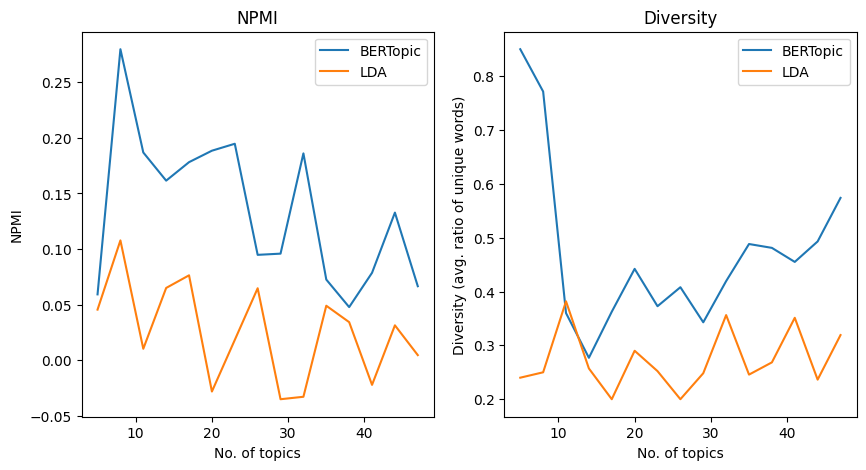

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(plot_data[:, 0], plot_data[:, 1], label='BERTopic')
axes[0].plot(plot_data[:, 0], plot_data[:, 2], label='LDA')
axes[0].set_xlabel('No. of topics')
axes[0].set_ylabel('NPMI')
axes[0].set_title('NPMI')
axes[0].legend()

axes[1].plot(plot_data[:, 0], plot_data[:, 3], label='BERTopic')
axes[1].plot(plot_data[:, 0], plot_data[:, 4], label='LDA')
axes[1].set_xlabel('No. of topics')
axes[1].set_ylabel('Diversity (avg. ratio of unique words)')
axes[1].set_title('Diversity')
axes[1].legend()

plt.show()

We can see that for all tested numbers of topics BERTopic offers both higher diversity and NPMI (with only a single exception).